# Prediction of accident severity using machine learning

## 1. Introduction

Modeling the severity of car crashes has long been an important area of research in road safety due to their prevalence and severe impact. According to TfL (Transport for London), there were 23,139 recorded crashes in London in 2021, resulting in 75 fatalities, 3505 serious injuries, and 23,092 minor injuries. The effects of road accidents include not only unemployment and associated economic hardship, such as loss of amenities and the devastating impact on the functioning of the entire household, but also the psychological impact of the crash (Másilková, 2017).

In order to mitigate the negative impacts of road accidents, this paper outlines an analytical approach and predictions of accident severity in London to understand influencing factors and spatial differences.

### 1.2 Import required packages

In [1]:
import math
from math import ceil

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, recall_score

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline

# CART
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost
from xgboost import XGBClassifier, plot_importance

#KNN
from sklearn.neighbors import KNeighborsClassifier

# dbscan, k-means
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline


## 2. Literature review

To reduce the negative consequences of collisions on virtual vehicle safety, crash data needs to be analysed and further injury severity prediction models developed. Regression is the most common method for studying crash severity variables, e.g., negative binomial (NB) models (Yan et al., 2020), logistic regression (LR) (Al-Ghamdi, 2002), and generalised linear regression (Osama and Sayed, 2017). Due to the spatio-temporal correlation of accidents and the sequential structure of injury severity categories (i.e., there may be common unobserved effects between neighbouring injury categories), several studies have modified standard data analysis approaches. For instance, Osama and Sayed (2017) employed generalised linear regression and full Bayesian methods to explore the link between pedestrian-vehicle collisions and many regional factors in Vancouver (i.e., spatial effects). Collisions were positively connected with socioeconomic indicators including population density, built environment elements like bus stops and traffic lights, business district density, and the percentage of arterial collector roads. Mohamed et al. (2013) also partitioned the crash dataset into homogeneous subsets using cluster generation based on crash characteristics like traffic control, lighting circumstances, car type, land use, movement type, environmental conditions, and missing features. Afterwards, the datasets for New York City and Montréal were analysed using regressions with clustering-based ordered probit (OP) models and MNL models. In their analysis, the authors identified additional variables that influence the severity of accidents, including heavy vehicles, dim lighting, mixed land use, and main roads. In addition, Chen, Zhang, Huang, et al. (2016) predicted New Mexico for the next two years using ordered logit models. The authors discovered that intersection location, number of vehicles involved, kind of incident, and roadway condition strongly influenced crash severity. In contrast to previous findings by Al-Ghamdi (2002), however, the study revealed that intersections are collision hotspots for more severe injury outcomes.

However, regression-based models require a proper function to relate the dependent variable with the independent variable. Moreover, the large amount of complex crash data currently available makes it difficult to investigate effectively using statistical models (Mannering, Shankar and Bhat, 2016). Therefore, previous researchers have proposed non-parametric machine learning methods to assess traffic collision severity, such as Bayesian networks (de Oña, Mujalli and Calvo, 2011), decision trees (DT) (Montella et al., 2011), classification and regression trees (CART) (Pakgohar et al., 2011; Chang and Wang, 2006), and XGBoost (Shen and Wei, 2020). Chang and Wang (2006) analyzed Taiwan accident data from 2001 using the CART model. The results showed that crash severity was most affected by vehicle type, accident type, crash environment, and driver/vehicle mobility. Pakgohar et al. (2011) investigated how human factors affect road traffic collisions using CART and LR methods. The authors discovered that driver age was significantly and negatively related to the fatal accident incidence in Iran, while gender was not significantly related to injury severity, with the CART method producing more precise results than the LR method.

In addition to traditional statistical and machine learning methods, deep learning methods have been used as predictive models for injury severity analysis due to their capacity to capture nonlinear relationships between input and output data (Polson and Sokolov, 2017). These include the Support Vector Machine (SVM) (Delen et al., 2017), the Artificial Neural Network (ANN) (Abdelwahab and Abdel-Aty, 2001; Kunt, Aghayan and Noii, 2011), and some neural network variants (e.g., Deep Neural Networks (DNNs) (Sze et al., 2017) and Recurrent Neural Networks (RNNs) (Sameen and Pradhan, 2017).

**Research Question** <br> 
Therefore, the core question of this research is 

    Question 1 | In London, what factors influence the severity of an accident and how can this impact be used to predict its severity?
    Question 2 | How do the factors affecting the severity of collisions vary in different spatial and temporal clusters?
 

## 3. Methodology

The study concentrates on the classification of road accident severity based on a variety of variables. It incorporates clustering and classification techniques to achieve more accurate results than a single classifier.

**Clustering method:**
Utilize k-means clustering to group similar accidents based on their characteristics, i.e., the severity rate of the accident. This will identify the characteristics of the data for further investigation.

**Classification methods:**
In this classification analysis, the three prediction algorithms CART, RF, and XGBoost are employed.

## 4. Presentation of data

### 4.1 Data source

The accident datasets used in this analysis for the years 2017 to 2021 were provided by the UK Department for Transport. Three crash-related datasets were selected for this study: the crash information dataset, the casualty information dataset, and the vehicle information dataset. Available from [open data source](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data).

In [2]:
#load data
accident=pd.read_csv('https://media.githubusercontent.com/media/xinyi8888/DSSS/main/dft-road-casualty-statistics-accident-last-5-years.csv', low_memory=False)
casualty=pd.read_csv('https://media.githubusercontent.com/media/xinyi8888/DSSS/main/dft-road-casualty-statistics-casualty-last-5-years.csv', low_memory=False)
age = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/DSSS/main/age.csv')
vehicle_age = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/DSSS/main/age_of_vehicle.csv')
London=gpd.read_file('https://github.com/xinyi8888/DSSS/blob/main/LSOA2011LondongenMHW.shp.zip?raw=true')
print('Done.')

Done.


In addition, we load the LSOA shapefile for London.

In [3]:
#Transfer CRS and rename columns of London LSOA boroughs
london_proj = London.to_crs(epsg=4326) #transform CRS to match Airbnb's
london_proj_LSOA = london_proj.loc[:,['LSOA11CD', 'geometry']].rename(columns={'LSOA11CD': 'LSOA code'})
london_proj = london_proj.loc[:,['geometry']]
london_proj.head()

,geometry
0,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


### 4.2 Preparing data sets

#### Merging data frames

Following that, we merged all the datasets to create a reference dataset and then created a replica set for future analysis.

In [4]:
#Collating vehicle information
vehicle_age = vehicle_age.rename(columns={'age_of_vehicle':'vehicle_age'})
age = age.loc[:,['accident_reference', 'age_band_of_casualty']]
vehicle = vehicle_age.merge(age, on='accident_reference', how='left')
vehicle.head()

,accident_reference,vehicle_age,vehicle_manoeuvre,engine_capacity_cc,vehicle_type,age_band_of_casualty
0,10001708,1,Going ahead other,1997,Car,16-20
1,10001708,1,Going ahead other,1997,Car,16-20
2,10001708,1,Going ahead other,1997,Car,16-20
3,10001708,-1,Going ahead other,-1,Motorcycle,16-20
4,10001708,-1,Going ahead other,-1,Motorcycle,16-20


In [5]:
#Merging data sets
accident = accident.drop(columns=['accident_index', 'accident_year'])
casualty = casualty.drop(columns=['age_band_of_casualty'])
casualty_total = casualty.merge(accident, on='accident_reference', how='left')
casualty_total = casualty_total.merge(vehicle, on='accident_reference', how='left')
casualty_total['time'] = casualty_total.loc[:,'time'].str.split(':', expand=True)[0]
casualty_total = casualty_total.rename(columns={'lsoa_of_accident_location':'LSOA code'})
casualty_total = casualty_total[casualty_total['casualty_class'] == 'Driver or rider']
casualty_total.head()

,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,casualty_severity,pedestrian_location,...,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,LSOA code,vehicle_age,vehicle_manoeuvre,engine_capacity_cc,vehicle_type,age_band_of_casualty
6,2017010001708,2017,10001708,2,2,Driver or rider,Male,19,Serious,Not a Pedestrian,...,None,Urban,Yes,Non-trunk,E01001450,1,Going ahead other,1997,Car,16-20
7,2017010001708,2017,10001708,2,2,Driver or rider,Male,19,Serious,Not a Pedestrian,...,None,Urban,Yes,Non-trunk,E01001450,1,Going ahead other,1997,Car,16-20
8,2017010001708,2017,10001708,2,2,Driver or rider,Male,19,Serious,Not a Pedestrian,...,None,Urban,Yes,Non-trunk,E01001450,1,Going ahead other,1997,Car,16-20
9,2017010001708,2017,10001708,2,2,Driver or rider,Male,19,Serious,Not a Pedestrian,...,None,Urban,Yes,Non-trunk,E01001450,-1,Going ahead other,-1,Motorcycle,16-20
10,2017010001708,2017,10001708,2,2,Driver or rider,Male,19,Serious,Not a Pedestrian,...,None,Urban,Yes,Non-trunk,E01001450,-1,Going ahead other,-1,Motorcycle,16-20


#### Focusing and splitting the dataframe

In this dataset, casualty severity has three levels: fatal, serious, and minor. Additionally, based on earlier research, this study analyzes and predicts accident severity using temporal and spatial information (time and location) and 12 additional influencing factors.

In [6]:
#Extracting month and date information
casualty_total['day'] = casualty_total['date'].str.split('/', expand=True)[0]
casualty_total['month'] = casualty_total['date'].str.split('/', expand=True)[1]

#First screening of influencing factors based on previous experience
casualty_total_classifier = casualty_total.copy()
casualty_total_classifier = casualty_total.loc[:,['accident_year', 'casualty_severity', 'sex_of_casualty', 'age_band_of_casualty', 
                                                  'road_type', 'junction_detail', 'speed_limit', 'light_conditions', 'weather_conditions',
                                                  'road_surface_conditions', 'urban_or_rural_area',
                                                  'vehicle_age', 'vehicle_manoeuvre', 'vehicle_type',
                                                  'month','day', 'day_of_week', 'time', 'LSOA code', 'longitude', 'latitude']]


#Reordering
casualty_total_classifier = casualty_total_classifier.reset_index()
casualty_total_classifier.head()

,index,accident_year,casualty_severity,sex_of_casualty,age_band_of_casualty,road_type,junction_detail,speed_limit,light_conditions,weather_conditions,...,vehicle_age,vehicle_manoeuvre,vehicle_type,month,day,day_of_week,time,LSOA code,longitude,latitude
0,6,2017,Serious,Male,16-20,Single carriageway,Not at junction or within 20 metres,30,Darkness - lights lit,Fine no high winds,...,1,Going ahead other,Car,08,05,Saturday,3,E01001450,-0.0801,51.6501
1,7,2017,Serious,Male,16-20,Single carriageway,Not at junction or within 20 metres,30,Darkness - lights lit,Fine no high winds,...,1,Going ahead other,Car,08,05,Saturday,3,E01001450,-0.0801,51.6501
2,8,2017,Serious,Male,16-20,Single carriageway,Not at junction or within 20 metres,30,Darkness - lights lit,Fine no high winds,...,1,Going ahead other,Car,08,05,Saturday,3,E01001450,-0.0801,51.6501
3,9,2017,Serious,Male,16-20,Single carriageway,Not at junction or within 20 metres,30,Darkness - lights lit,Fine no high winds,...,-1,Going ahead other,Motorcycle,08,05,Saturday,3,E01001450,-0.0801,51.6501
4,10,2017,Serious,Male,16-20,Single carriageway,Not at junction or within 20 metres,30,Darkness - lights lit,Fine no high winds,...,-1,Going ahead other,Motorcycle,08,05,Saturday,3,E01001450,-0.0801,51.6501


In the code below, this study performs data cleansing (e.g., removing absent values), reduction to London areas, and data type conversion on the collected traffic accident record data.

In [7]:
#Data cleaning
#Excluding data with no clear location
casualty_total_classifier = casualty_total_classifier[~(casualty_total_classifier.longitude.isna())]
casualty_total_classifier = casualty_total_classifier[~(casualty_total_classifier['LSOA code'].isin([-1]))]
#Excluded missing data
for i in list(casualty_total_classifier):
    casualty_total_classifier = casualty_total_classifier[~(casualty_total_classifier[i].isin(['Data missing or out of range', 'unknown (self reported)',
                                                                                   'Unknown', -1]))]
    
#Confirm missing values in the data
for i in list(casualty_total_classifier):
    num1=casualty_total_classifier[casualty_total_classifier[i].isnull()].shape[0]
    num2=casualty_total_classifier[casualty_total_classifier[i].isin(['Data missing or out of range','unknown (self reported)','Unknown',-1])].shape[0]
    num1 += num1
    num2 += num2

print(f"casualty_total has {num1} NaN.") 
print(f"casualty_total has {num2} missing data.")

casualty_total has 0 NaN.
casualty_total has 0 missing data.


In [8]:
#According to the latitude and longitude coordinates, the attribute data is converted into points for later spatial join
casualty_total_geo = gpd.GeoDataFrame(casualty_total_classifier, geometry=gpd.points_from_xy(casualty_total_classifier.longitude, casualty_total_classifier.latitude))
casualty_total_geo = casualty_total_geo.set_crs(epsg=4326)

casualty_total_geo = casualty_total_geo.drop(['index'], axis=1)

#cleaning null data
for i in list(casualty_total_geo):
    casualty_total_geo = casualty_total_geo[~(casualty_total_geo[i].isna())]

In [9]:
#Narrowing the data to the London borough
casualty_total_geo = gpd.sjoin(casualty_total_geo, london_proj, how='right', predicate ='within')
casualty_total_geo = casualty_total_geo.reset_index()

#cleaning null data
for i in list(casualty_total_geo):
    casualty_total_geo = casualty_total_geo[~(casualty_total_geo[i].isna())]
    
#Converting data types
type_list = ['speed_limit', 'day', 'month', 'vehicle_age', 'time', 'accident_year', ]
for i in type_list:
    casualty_total_geo[i] = casualty_total_geo[i].astype('int')

#Check the type of data
casualty_total_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 159266 entries, 0 to 159434
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    159266 non-null  int64   
 1   index_left               159266 non-null  float64 
 2   accident_year            159266 non-null  int64   
 3   casualty_severity        159266 non-null  object  
 4   sex_of_casualty          159266 non-null  object  
 5   age_band_of_casualty     159266 non-null  object  
 6   road_type                159266 non-null  object  
 7   junction_detail          159266 non-null  object  
 8   speed_limit              159266 non-null  int64   
 9   light_conditions         159266 non-null  object  
 10  weather_conditions       159266 non-null  object  
 11  road_surface_conditions  159266 non-null  object  
 12  urban_or_rural_area      159266 non-null  object  
 13  vehicle_age              159266 non-

In [10]:
casualty_total_geo.shape

(159266, 24)

In [11]:
#Calculate the frequency of casualty in each area
casualty_frequency = casualty_total_geo.groupby(['LSOA code', 'casualty_severity'])['casualty_severity'].count()

#Reducing multiple indexes to a single level
casualty_frequency = casualty_frequency.to_frame().unstack()
casualty_frequency.columns = casualty_frequency.columns.droplevel(0)

#Linking datasets to LSOA layers
casualty_frequency = london_proj_LSOA.merge(casualty_frequency, on='LSOA code', how='left')
casualty_frequency = casualty_frequency.set_crs(epsg=4326)

casualty_kmeans = casualty_frequency.drop(['geometry'], axis=1).set_index('LSOA code')
casualty_kmeans = casualty_kmeans.replace([np.nan],0)

casualty_kmeans.head()

,Fatal,Serious,Slight
LSOA code,,,
E01000001,0.0000,7.0000,28.0000
E01000002,0.0000,0.0000,23.0000
E01000003,0.0000,0.0000,2.0000
E01000005,0.0000,7.0000,69.0000
E01000006,0.0000,4.0000,2.0000


### 4.3 Presentation of data

This study analyzes spatial and temporal data to determine accident distributions using visualization approaches. The graph below shows the frequency of accidents for the three severity categories, which declines as severity increases.

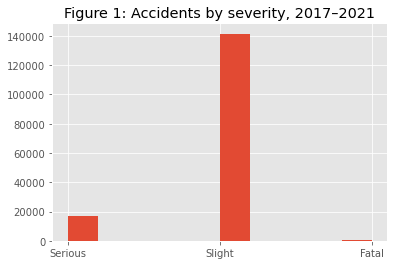

In [12]:
casualty_total_geo['casualty_severity'].hist()
plt.title('Figure 1: Accidents by severity, 2017–2021')
plt.show()

First, the paper examines the temporal distribution of incidents with different injury severity levels. Figure 2 shows that the number of incidents resulting in various injuries decreases annually and is highest in June and July and lowest in January and February. Figure 2 also demonstrates that Fridays and Saturdays have the most accidents, while Sundays have the fewest. Furthermore, the final graph in Figure 2 shows that 5 p.m. and 6 p.m. are the peak accident times, with a modest rise at 8 a.m., which may be attributed to commuting hours.

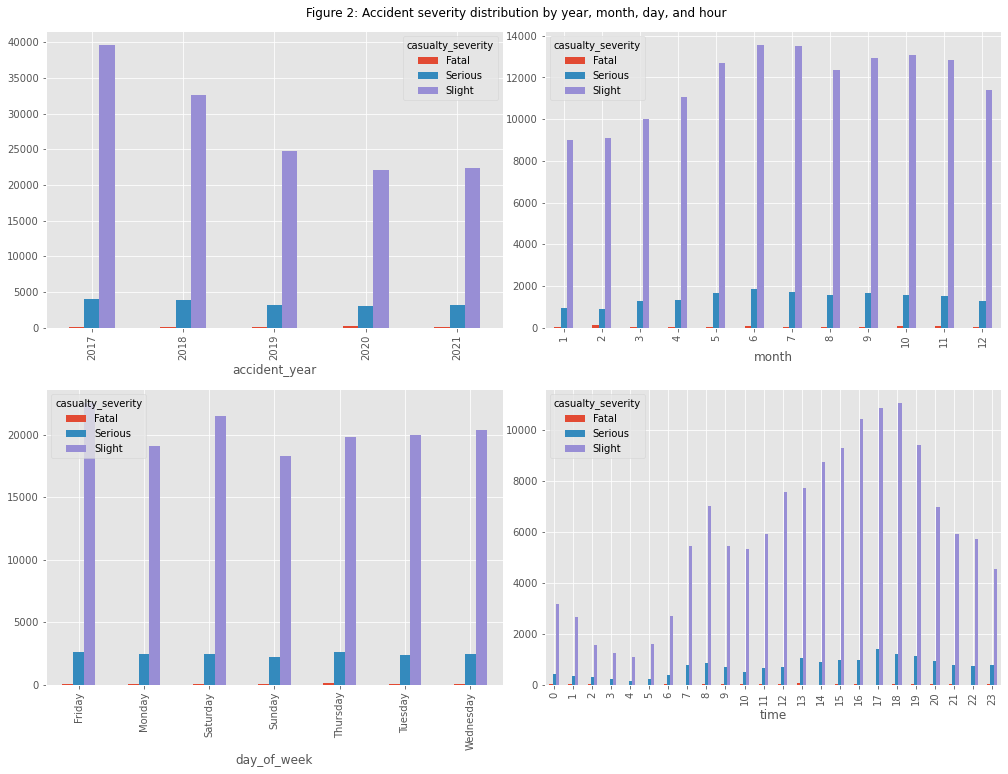

In [13]:
group_by_list = ['accident_year', 'month', 'day_of_week', 'time']
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
fig.suptitle('Figure 2: Accident severity distribution by year, month, day, and hour')
fig.tight_layout(h_pad=4)

for i in group_by_list:
    distribution = casualty_total_geo.groupby([i, 'casualty_severity'])['casualty_severity'].count().to_frame().unstack()
    distribution.columns = distribution.columns.droplevel(0)
    distribution = distribution.replace([np.nan],0)
    if group_by_list.index(i) <= 1:
        distribution.plot.bar(y=['Fatal', 'Serious', 'Slight'], fontsize=(10), ax=axes[0,group_by_list.index(i)])
        
    else:
        distribution.plot.bar(y=['Fatal', 'Serious', 'Slight'], fontsize=(10), ax=axes[1,group_by_list.index(i)-2])

This article additionally compares the spatial distribution of incidents with different injury severity levels. Figure 3 shows that accidents are spatially clustered, with accident density remaining roughly stable across severity levels. However, since fatal accidents are far fewer than the other two levels, this may result in the area's accident density being lower. In addition, some parts of the suburbs and city centres have higher accident rates, including the northern part of Enfield, the southwestern corner of Hillingdon, the southern part of Havering, the south-eastern corner of Newham, the City of London, and Westminster.

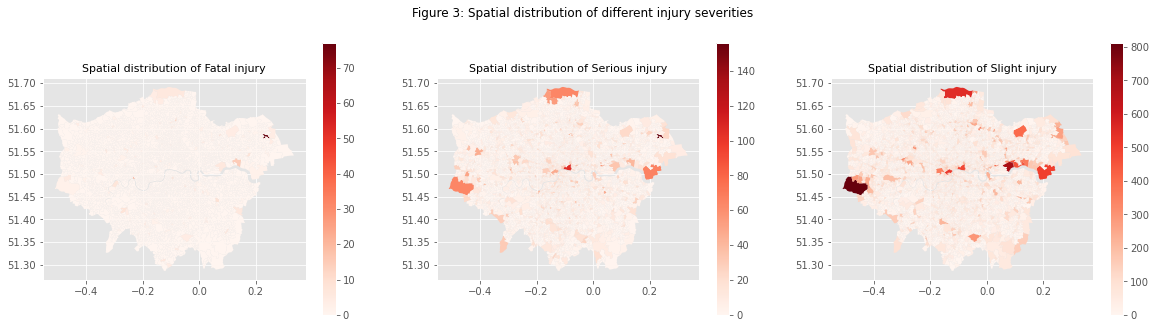

In [14]:
casualty_kmeans_plot = london_proj_LSOA.merge(casualty_kmeans, on='LSOA code', how='left')
severity_class=['Fatal', 'Serious', 'Slight']

fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3)
fig.suptitle('Figure 3: Spatial distribution of different injury severities')
#fig.tight_layout(h_pad=4)

for i in severity_class:
    casualty_kmeans_plot.plot(column=casualty_kmeans_plot[i], legend= True, cmap='Reds', ax=axes[severity_class.index(i)])
    axes[severity_class.index(i)].set_title('Spatial distribution of '+i+' injury', fontsize=11)


## 5. Results

In order to properly analyse the research questions presented in this paper, the analysis can be divided into three parts:

1. Apply CART, RF, and XGBoost to the prepared dataset and visualize the results (including performance and significance). 
2. Perform clustering and combine the clustered results with the initial dataset.  
3. The initial analysis step is repeated for each clustering

The code is shown below.

### 5.1 CART, RF and XGBoost

#### Function

The main purpose of the function `getscore` is to obtain statistical values that reflect the performance of the categories.

In addition, since the method `plot_importance()` can only return the importance of the different codes generated by the category variables in the method, and not the overall importance of the variables in that category, the equation `sumimportance` mainly addresses the problem of collating the overall importance of the different variables in that category.

In [15]:
def getscore(y_true, y_pred):
    precision, recall, f1 = 0, 0, 0
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

In [16]:
#Define function to convert the importance rank
def sumimportance(model):
    #Converting dictionary to dataframe
    importance_data = pd.DataFrame(model[1].feature_importances_, index=model[:-1].get_feature_names_out())
    importance_data = pd.DataFrame(importance_data.values.T,columns=importance_data.index,index=importance_data.columns.values)
    importance_total = pd.DataFrame()
    
    #Combine the same category
    for i in range(0,len(importance_data.columns.to_list())):
        name1 = importance_data.columns.to_list()[i]
        columns = '_'.join(importance_data.columns.to_list()[i].split('_')[1:4])[1:]
        importance_total.at[0, columns] = importance_data.loc[0, importance_data.columns.to_list()[i]]
    
    for j in range(i+1,len(importance_data.columns.to_list())):
        name2 = importance_data.columns.to_list()[j].split('_')[:4]
        
        if name1 == name2:
            importance_total.loc[0, columns] = importance_total.loc[0, columns] + importance_data.loc[0, importance.columns.to_list()[j]]
    
    for s in range(0, i-1):
        name3 = importance_data.columns.to_list()[s].split('_')[:4]
        
        if name1 == name3:
            importance_total.drop([columns],axis=1)

    #Rename
    importance_total = importance_total.rename(columns={'age_of':'age_of_casualty', 'number_of':'number_of_vehicles', 'sex_of':'sex_of_casualty',
                                'pedestrian_crossing':'pedestrian_crossing_human_control', 'road_surface':'road_surface_conditions',
                                'urban_or':'urban_or_rural_area'})
    importance_total_T = pd.DataFrame(importance_total.values.T,columns=importance_total.index,index=importance_total.columns.values)
    
    return importance_total_T

#### Splitting data and encode categorical features

First, the prepared dataset is split into a training set and a test set using the method `train_test_split()`, and they are encoded (for categorical variables) and normalised (for numeric variables), respectively.

In [17]:
X = casualty_total_geo.drop(['index_left', 'index', 'casualty_severity', 'day_of_week', 
                              'accident_year', 'time', 'day', 'month', 'geometry', 'longitude', 'latitude', 'LSOA code'], axis = 1)
y = casualty_total_geo['casualty_severity']

#Splitting data into random train and test subsets
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=random_state_split)

#Encode casualty_severity
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

In [18]:
#One-hot encoding categorical features
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder(drop='first')) #drop the first category in each feature. If only one category is present, the feature will be dropped entirely.
])

In [19]:
#Specify which columns are numeric and which are categorical
numeric_features = ['speed_limit', 'vehicle_age']
categorical_features = ['sex_of_casualty', 'age_band_of_casualty', 'road_type', 
                        'junction_detail', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 
                        'urban_or_rural_area', 'vehicle_manoeuvre', 'vehicle_type']
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
])

#### Classification

Then this paper uses classification and regression trees, random forests, and XGBoost on this dataset to compare the accuracy scores and F1 values of the various methods.

In [20]:
classifier = {
    'CART': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier()
}

# a dict to store the R2 of training and testing data
dict_results = dict()
importance = pd.DataFrame()
confusion_matrix_num = dict()

classes = ['Fatal', 'Serious', 'Slight']
classifier_list=['CART', 'RF', 'XGB']

for name, classifier in classifier.items():
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classifier', classifier)
           ])
    model = pipeline.fit(train_x, train_y)
    
    importance = pd.concat([importance, sumimportance(model)], axis=1)
    
    train_score = accuracy_score(train_y, model.predict(train_x))
    test_score = accuracy_score(test_y, model.predict(test_x))
    dict_results[name] = [train_score, test_score, train_score - test_score]
    
    precision, recall, f1 = getscore(test_y, model.predict(test_x))
    confusion_matrix_num[name] = [precision, recall, f1]
    

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
classification_score = pd.DataFrame.from_dict(confusion_matrix_num, orient='index', columns=['precision', 'recall', 'f1'])
df_models

,R2_train_data,R2_test_data,R2_diff
CART,0.9535,0.8305,0.1231
RF,0.9535,0.8746,0.0789
XGB,0.8914,0.8919,-0.0006


In [21]:
classification_score

,precision,recall,f1
CART,0.4374,0.4373,0.4372
RF,0.4812,0.3961,0.4161
XGB,0.5836,0.3680,0.3727


As shown above, all three methods of classification performed well in the training set. On the training set, CART and RF have the same maximum accuracy scores. However, compared to RF, the CART method only has an accuracy value of 0.8305 on the test set, and its accuracy score difference between the training and test sets is the greatest of the three methods, at 0.1231. The XGBoost method's accuracy on the training set is 0.8914, but its accuracy on the test set is greater, with a difference of -0.0006. Furthermore, it is crucial to note that XGB's precision is too high and its recall value is too low, resulting in a lower F1 score when comparing the three approaches' performance.

#### Visualize each factor's importance

Finally, the analysis provides a bar plot of the significance ratings for each variable used in the three classifications, and the variables are ranked by the XGBoost algorithm. The graph shows that XGBoost's classification variables are relatively equally weighted compared to CART and RF. Furthermore, the severity of injuries is most affected by the four factors, i.e., the driver's gender, lighting, speed limits, and road conditions. This suggests that several environmental factors have a greater impact on accident-related injuries. In contrast, vehicle attributes have relatively little impact on collision injuries. However, as demonstrated in the graph below, for both RF and CART techniques, vehicle age has the highest impact on accident injuries, followed by the speed limit and road conditions. Additionally, weather factors have little impact.

Text(0.5, 1.0, 'Figure 4: The importance of factors in classification')

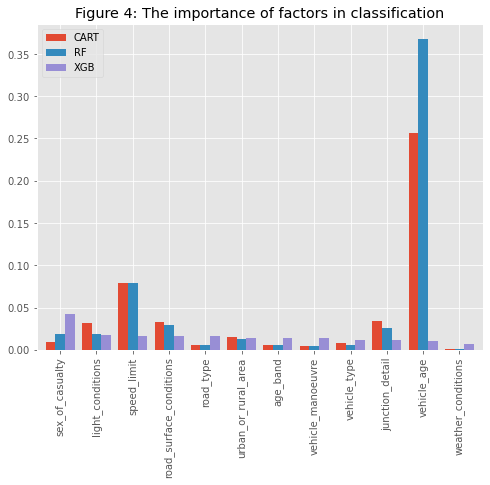

In [22]:
importance.columns = ['CART', 'RF', 'XGB']
importance.sort_values('XGB',ascending=False, inplace=True)
importance.plot(kind='bar', width = 0.8, figsize=(8,6))
plt.title('Figure 4: The importance of factors in classification')

### 5.2 K-means

In the second part of this paper, K-means clustering is used to capture the spatial patterns of a large dataset of accident records.

#### Function

The purpose of the `mapping_clusters` function is to plot the clustering results and add the clustering labels to the initial dataset.

In [23]:
def mapping_clusters(labels_cluster):
    global casualty_kmeans
    
    #Adding clustering results to the original dataset
    casualty_kmeans['cluster_nm'] = labels_cluster
    casualty_kmeans = london_proj_LSOA.merge(casualty_kmeans, on = 'LSOA code', how='left')
    casualty_kmeans = casualty_kmeans.set_crs(epsg=4326)
    casualty_kmeans.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Blues');
    plt.title('Figure 6: Clustering results')
    casualty_kmeans['cluster_nm'] = casualty_kmeans['cluster_nm'].astype('str')

#### Find the 'right' number of clusters

The k-means approach requires specifying the number of classes to divide the dataset into. In most cases, it is possible to determine the optimal k-value for k-means using the elbow method (Liu and Deng, 2021). As shown in Figure 5, this analysis's spatial clustering results can be separated into four classes.

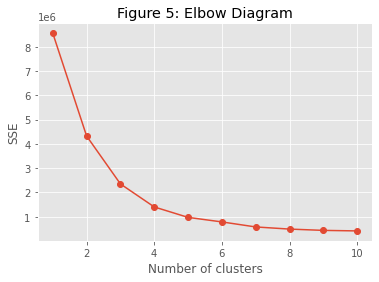

In [24]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(casualty_kmeans)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Figure 5: Elbow Diagram')
plt.show()

#### Cluster

In [25]:
k_cluster = 4
random_seed = 4
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(casualty_kmeans)

KMeans(n_clusters=4, random_state=4)

This analysis classifies London's LSOA areas into four categories based on the frequency of three kinds of accidents (slight, serious, and deadly). According to the graph, places near each other are more likely to belong to the same cluster, while the different clusters are more dispersed.

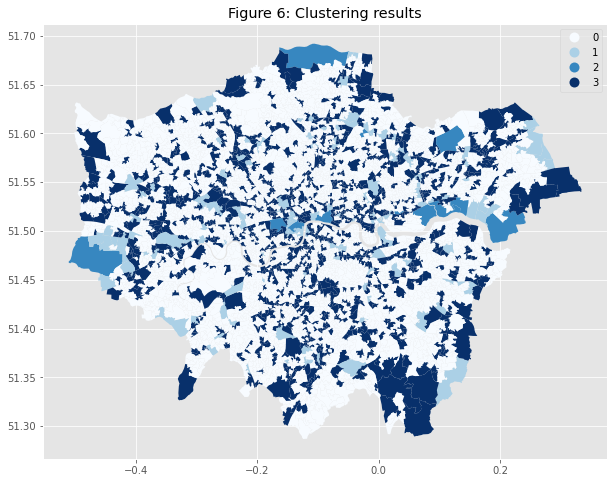

In [26]:
mapping_clusters(kmeans_method.labels_);

In [27]:
casualty_kmeans

,LSOA code,geometry,Fatal,Serious,Slight,cluster_nm
0,E01000001,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",0.0000,7.0000,28.0000,0
1,E01000002,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",0.0000,0.0000,23.0000,0
2,E01000003,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",0.0000,0.0000,2.0000,0
3,E01000005,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",0.0000,7.0000,69.0000,3
4,E01000006,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",0.0000,4.0000,2.0000,0
...,...,...,...,...,...,...
4830,E01033742,"POLYGON ((0.08240 51.49886, 0.08415 51.49803, ...",0.0000,0.0000,0.0000,0
4831,E01033743,"POLYGON ((0.11081 51.50980, 0.11227 51.50782, ...",0.0000,1.0000,14.0000,0
4832,E01033744,"POLYGON ((0.08072 51.49550, 0.08165 51.49491, ...",0.0000,2.0000,17.0000,0
4833,E01033745,"POLYGON ((0.10806 51.50135, 0.10664 51.50021, ...",0.0000,7.0000,62.0000,3


### 5.3 Incorporate

After accounting for the spatial similarity of the incident locations (as shown by the clustering findings), CART, RF, and XGBoost are employed again to estimate the severity of the occurrences.

#### Function

The primary purpose of the equation`ml_sum` is to summarize the code for making predictions using the three methods and to make the code that follows simplified.

In [28]:
def ml_sum(data_kmean):
    X_kmeans = data_kmean.drop(['index', 'index_left', 'accident_year', 'casualty_severity', 'day', 'cluster_nm',
                                'geometry', 'longitude', 'latitude', 'LSOA code'], axis = 1)
    y_kmeans = data_kmean['casualty_severity']
    
    #Splitting data into random train and test subsets
    random_state_split = 123
    train_x_kmeans, test_x_kmeans, train_y_kmeans, test_y_kmeans = train_test_split(X_kmeans, y_kmeans, random_state=random_state_split)
    
    #Encode casualty_severity
    le = LabelEncoder()
    train_y_kmeans = le.fit_transform(train_y_kmeans)
    test_y_kmeans = le.fit_transform(test_y_kmeans)
    
    #Specify which columns are numeric and which are categorical
    numeric_features = ['speed_limit', 'vehicle_age', 'time', 'month']
    categorical_features = ['sex_of_casualty', 'age_band_of_casualty', 'road_type', 
                        'junction_detail', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 
                        'urban_or_rural_area', 'vehicle_manoeuvre', 'vehicle_type', 'day_of_week']
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features)
            ,('categorical', categorical_transformer, categorical_features)
            
        ])
    
    classifier = {
    'CART': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier()
    }
    
    # a dict to store the R2 of training and testing data
    dict_results_kmeans = dict()
    importance_kmeans = pd.DataFrame()
    
    for name, classifier in classifier.items():
        pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classifier', classifier)
           ])
        model = pipeline.fit(train_x_kmeans, train_y_kmeans)
        importance_kmeans = pd.concat([importance_kmeans, sumimportance(model)], axis=1)
        
        train_score = accuracy_score(train_y_kmeans, model.predict(train_x_kmeans))
        test_score = accuracy_score(test_y_kmeans, model.predict(test_x_kmeans))
        dict_results_kmeans[name] = [train_score, test_score, train_score - test_score]
        
        precision, recall, f1 = getscore(test_y_kmeans, model.predict(test_x_kmeans))
        confusion_matrix_num[name] = [precision, recall, f1]
        
    #Transform dict_models to dataframe
    df_models_kmeans = pd.DataFrame.from_dict(dict_results_kmeans, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
    confusion_matrix_num_kmeans = pd.DataFrame.from_dict(confusion_matrix_num, orient='index', columns=['precision', 'recall', 'f1'])
    importance_kmeans.columns = ['CART', 'RF', 'XGB']
    importance_kmeans.sort_values('XGB',ascending=False, inplace=True)
    return df_models_kmeans, importance_kmeans, confusion_matrix_num_kmeans

#### Clasification

The code below predicts the severity of accidents for the clustered dataset.

In [29]:
list_cluster = ['0','1','2','3']
casualty_total_kmeans = casualty_total_geo.merge(casualty_kmeans.drop(['geometry', 'Fatal', 'Serious', 'Slight'], axis = 1), on='LSOA code', how='left')
dict_results_kmeans = pd.DataFrame()
importance_kmeans = pd.DataFrame()
confusion_matrix_kmeans = pd.DataFrame()
    
for i in list_cluster:
    #Splitting the dataset into different groups based on cluster results
    casualty_cluster_kmeans = casualty_total_kmeans[casualty_total_kmeans['cluster_nm']==i]
    #As there was only one accident in Cluster 1 regarding an agricultural vehicle, it should be removed.
    if i == '1':
        casualty_cluster_kmeans = casualty_cluster_kmeans[~(casualty_cluster_kmeans['vehicle_type']=='Agricultural vehicle')]
    dict_results, importance_results, confusion_matrix_num_kmeans = ml_sum(casualty_cluster_kmeans)
    
    #Change the names of the two datasets to avoid confusion
    dict_results.index = ['cluster_'+ str(i) +'_CART', 'cluster_'+ str(i) +'_RF', 'cluster_'+ str(i) +'_XGB']
    importance_results.columns = ['cluster_'+ str(i) +'_CART', 'cluster_'+ str(i) +'_RF', 'cluster_'+ str(i) +'_XGB']
    confusion_matrix_num_kmeans.index = ['cluster_'+ str(i) +'_CART', 'cluster_'+ str(i) +'_RF', 'cluster_'+ str(i) +'_XGB']
    
    #Merge data from each cluster
    dict_results_kmeans = pd.concat([dict_results, dict_results_kmeans])
    importance_kmeans = pd.concat([importance_results, importance_kmeans], axis=1)
    confusion_matrix_kmeans = pd.concat([confusion_matrix_kmeans, confusion_matrix_num_kmeans])
    
dict_results_kmeans

,R2_train_data,R2_test_data,R2_diff
cluster_3_CART,0.9865,0.8500,0.1365
cluster_3_RF,0.9865,0.8969,0.0896
cluster_3_XGB,0.9117,0.8992,0.0125
cluster_2_CART,0.9776,0.8858,0.0918
cluster_2_RF,0.9776,0.9148,0.0628
cluster_2_XGB,0.9747,0.9154,0.0593
cluster_1_CART,0.9770,0.8866,0.0904
cluster_1_RF,0.9769,0.9153,0.0617
cluster_1_XGB,0.9456,0.9220,0.0236
cluster_0_CART,0.9882,0.8006,0.1876


The code below combines the accuracy ratings and f1 values from the previous section with the data frames from the second program for comparative analysis.

In [30]:
df_models_kmeans = pd.DataFrame()
df_models_kmeans = pd.concat([df_models, df_models])
df_models_kmeans = pd.concat([df_models, df_models_kmeans])
df_models_kmeans = pd.concat([df_models, df_models_kmeans])
df_models_kmeans.columns = ['R2_train_data_before_cluster', 'R2_test_data_before_cluster', 'R2_diff_before_cluster']
df_models_kmeans.index = dict_results_kmeans.index
df_models_kmeans = pd.concat([df_models_kmeans, dict_results_kmeans], axis=1)

f1_kmeans = pd.DataFrame()
f1_kmeans = pd.concat([classification_score, classification_score])
f1_kmeans = pd.concat([classification_score, f1_kmeans])
f1_kmeans = pd.concat([classification_score, f1_kmeans])
f1_kmeans.columns = ['precision_before_cluster', 'recall_before_cluster', 'f1_before_cluster']
f1_kmeans.index = dict_results_kmeans.index
f1_kmeans = pd.concat([f1_kmeans, confusion_matrix_kmeans], axis=1)

In [31]:
#To show these changes more clearly, the indexes of the data frame are reordered
order=['cluster_0_CART', 'cluster_1_CART', 'cluster_2_CART', 'cluster_3_CART', 
       'cluster_0_RF', 'cluster_1_RF', 'cluster_2_RF', 'cluster_3_RF',
       'cluster_0_XGB', 'cluster_1_XGB', 'cluster_2_XGB', 'cluster_3_XGB']
df_new=pd.DataFrame()
dict_results_kmeans_new=pd.DataFrame()

for i in order:
    df_new = pd.concat([df_new, df_models_kmeans.loc[i,:]], axis=1)
    dict_results_kmeans_new = pd.concat([dict_results_kmeans_new, dict_results_kmeans.loc[i,:]], axis=1)
    
df_new = pd.DataFrame(df_new.values.T,columns=df_new.index,index=df_new.columns.values)
dict_results_kmeans_new = pd.DataFrame(dict_results_kmeans_new.values.T,columns=dict_results_kmeans_new.index,index=dict_results_kmeans_new.columns.values)

Figure 7 shows that clustering improved CART and RF accuracy on the majority of training and test sets. However, only the difference in accuracy scores between the training and test sets for clusters 1 and 2 dropped, while the values for classes 0 and 3 expanded. Additionally, although XGBoost improved accuracy scores on the training and test sets for classes 1 and 2, the difference grew correspondingly. Compared to the other two approaches, the discrepancies are still small and within acceptable bounds.

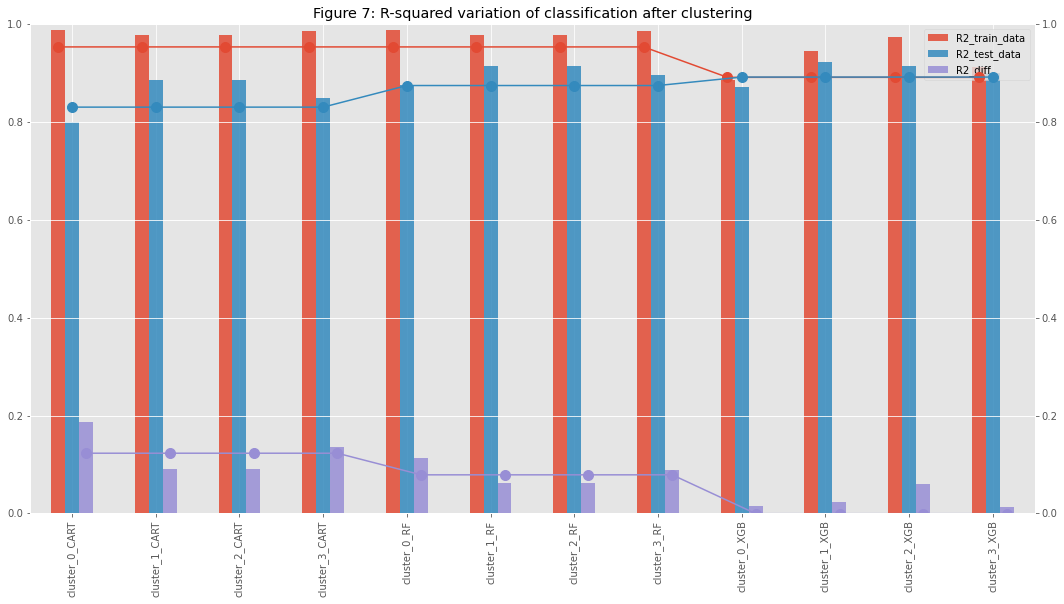

In [32]:
l=[i for i in range(df_models_kmeans.shape[0])]
dict_results_kmeans.sort_values('R2_test_data',ascending=False, inplace=True)

fig = plt.figure()
ax1 = fig.add_subplot(111)
dict_results_kmeans_new.plot(kind='bar', width = 0.5, figsize=(18,9), alpha=0.85, ax=ax1)
plt.ylim([0, 1.0])
ax2 = ax1.twinx()
ax2.plot([i-0.17 for i in l], df_new['R2_train_data_before_cluster'] ,marker='.', ms=20, label='R2_train_data_before_cluster')
ax2.plot(l, df_new['R2_test_data_before_cluster'] ,marker='.', ms=20, label='R2_test_data_before_cluster')
ax2.plot([i+0.17 for i in l], df_new['R2_diff_before_cluster'] ,marker='.', ms=20, label='R2_diff_before_cluster')
plt.title('Figure 7: R-squared variation of classification after clustering')
plt.ylim([0, 1.0])
plt.show()

Figure 8 illustrates that the performance of virtually all models improved after clustering. Moreover, the performance of the models is significantly enhanced when the three distinct methods are applied to cluster 2.

In [33]:
average_CART=(f1_kmeans.loc['cluster_0_CART', 'f1']+f1_kmeans.loc['cluster_1_CART', 'f1']+
              f1_kmeans.loc['cluster_2_CART', 'f1']+f1_kmeans.loc['cluster_3_CART', 'f1'])/4
average_RF=(f1_kmeans.loc['cluster_0_RF', 'f1']+f1_kmeans.loc['cluster_1_RF', 'f1']+
            f1_kmeans.loc['cluster_2_RF', 'f1']+f1_kmeans.loc['cluster_3_RF', 'f1'])/4
average_XGB=(f1_kmeans.loc['cluster_0_XGB', 'f1']+f1_kmeans.loc['cluster_1_XGB', 'f1']+
             f1_kmeans.loc['cluster_2_XGB', 'f1']+f1_kmeans.loc['cluster_3_XGB', 'f1'])/4

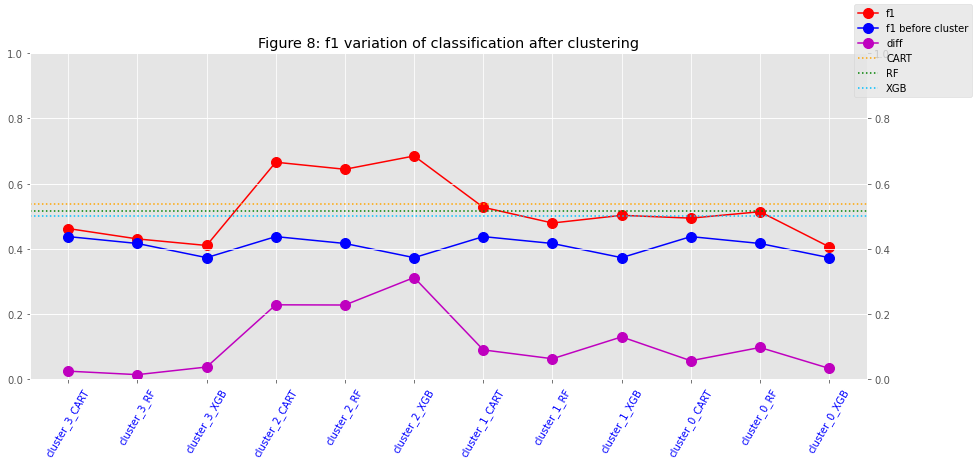

In [34]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.plot(f1_kmeans['f1'] , marker='.', color='r', ms=20, label='f1')
ax1.plot(f1_kmeans['f1_before_cluster'] , marker='.', color='b', ms=20, label='f1 before cluster')
ax1.plot(f1_kmeans['f1']-f1_kmeans['f1_before_cluster'] , marker='.', color='m', ms=20, label='diff')
plt.ylim([0, 1.0])
plt.xticks(range(0,len(f1_kmeans.index.to_list())), f1_kmeans.index,color='blue',rotation=60)
ax2 = ax1.twinx()
plt.axhline(y=average_CART,ls=":",c="orange", label='CART')
plt.axhline(y=average_RF,ls=":",c="green", label='RF')
plt.axhline(y=average_XGB,ls=":",c="deepskyblue", label='XGB')
plt.ylim([0, 1.0])
fig.legend(loc=1)
plt.title('Figure 8: f1 variation of classification after clustering')
plt.show()

#### Visualize each factor's importance

<AxesSubplot:>

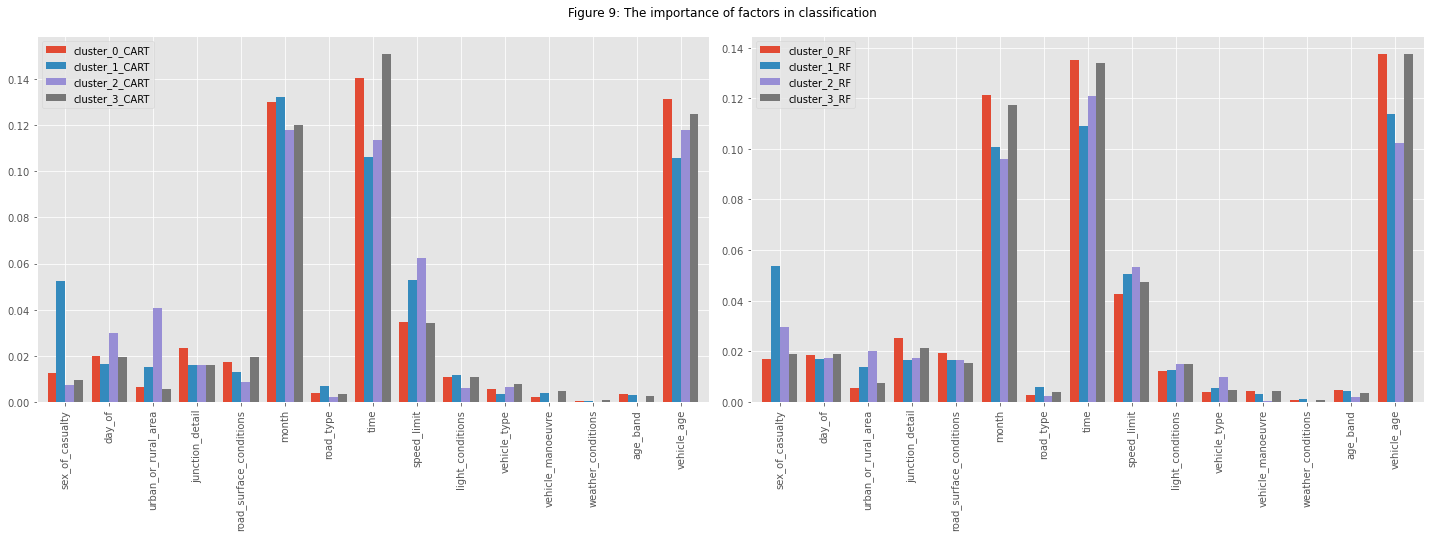

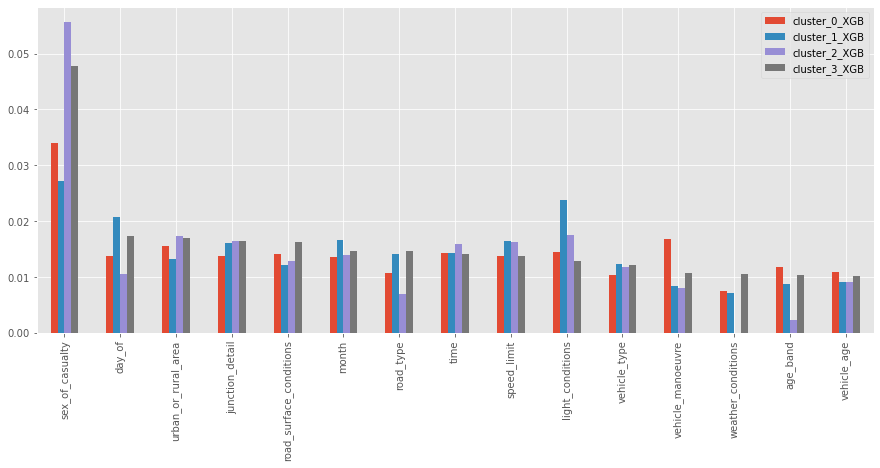

In [35]:
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.suptitle('Figure 9: The importance of factors in classification')
fig.tight_layout(h_pad=4)

importance_kmeans.loc[:,['cluster_0_CART', 'cluster_1_CART', 'cluster_2_CART', 'cluster_3_CART']].plot(kind='bar', width = 0.8, ax=axes[0])
importance_kmeans.loc[:,['cluster_0_RF', 'cluster_1_RF', 'cluster_2_RF', 'cluster_3_RF']].plot(kind='bar', width = 0.8, ax=axes[1])
importance_kmeans.loc[:,['cluster_0_XGB', 'cluster_1_XGB', 'cluster_2_XGB', 'cluster_3_XGB']].plot(kind='bar', width = 0.5, figsize=(15,6))

As seen above, when spatial and temporal characteristics are incorporated, the importance of the different variables in the different approaches varies, but the weights of the different variables in XGBoost are still substantially more equally distributed than in the other two methods. Month, time of day, vehicle age, and speed limit are the four parameters that most affect injury severity for both CART and RF. Furthermore, in addition to time, the environmental aspect was more important.

## 6. Discussion and coclusion

This paper examines the effects of environmental, vehicle-related, and driver-related variables on accident severity using classification and clustering, taking into consideration spatial and temporal characteristics, and explores the following research questions:

    Question 1 | In London, what factors influence the severity of an accident and how can this impact be used to predict its severity?
    Question 2 | How do the factors affecting the severity of collisions vary in different spatial and temporal clusters?

This study suggests that environmental factors have a greater impact on crash severity and that environmental variables remain significant after clustering. Moreover, based on the difference between accuracy scores and F1 values, the random forest method seems to be the relatively optimal method for predicting collision severity. Overall, this paper's findings emphasize the significance of environmental factors in determining accident severity, especially road conditions and lighting conditions. In addition, it emphasizes the spatial and temporal correlation of accidents. This means that it is possible to reduce losses by focusing on areas where incidents occur at specific times, but this will require further investigation.

## Reference

Abdelwahab, H.T. and Abdel-Aty, M.A. (2001) ‘Development of Artificial Neural Network Models to Predict Driver Injury Severity in Traffic Accidents at Signalized Intersections’, Transportation Research Record: Journal of the Transportation Research Board, 1746(1), pp. 6–13. Available at: https://doi.org/10.3141/1746-02.

Al-Ghamdi, A.S. (2002) ‘Using logistic regression to estimate the influence of accident factors on accident severity’, Accident Analysis & Prevention, 34(6), pp. 729–741. Available at: https://doi.org/10.1016/S0001-4575(01)00073-2.

Chang, L.-Y. and Wang, H.-W. (2006) ‘Analysis of traffic injury severity: An application of non-parametric classification tree techniques’, Accident Analysis & Prevention, 38(5), pp. 1019–1027. Available at: https://doi.org/10.1016/j.aap.2006.04.009.

Chen, C., Zhang, G., Huang, H., et al. (2016) ‘Examining driver injury severity outcomes in rural non-interstate roadway crashes using a hierarchical ordered logit model’, Accident Analysis & Prevention, 96, pp. 79–87. Available at: https://doi.org/10.1016/j.aap.2016.06.015.

Delen, D. et al. (2017) ‘Investigating injury severity risk factors in automobile crashes with predictive analytics and sensitivity analysis methods’, Journal of Transport & Health, 4, pp. 118–131. Available at: https://doi.org/10.1016/j.jth.2017.01.009.

Kunt, M.M., Aghayan, I. and Noii, N. (2011) ‘Prediction for traffic accident severity: comparing the artificial neural network, genetic algorithm, combined genetic algorithm and pattern search methods’, Transport, 26(4), pp. 353–366. Available at: https://doi.org/10.3846/16484142.2011.635465.

Liu, F. and Deng, Y. (2021) ‘Determine the Number of Unknown Targets in Open World Based on Elbow Method’, IEEE Transactions on Fuzzy Systems, 29(5), pp. 986–995. Available at: https://doi.org/10.1109/TFUZZ.2020.2966182.

Mannering, F.L., Shankar, V. and Bhat, C.R. (2016) ‘Unobserved heterogeneity and the statistical analysis of highway accident data’, Analytic Methods in Accident Research, 11, pp. 1–16. Available at: https://doi.org/10.1016/j.amar.2016.04.001.

Másilková, M. (2017) ‘Health and social consequences of road traffic accidents’, Kontakt, 19(1), pp. e43–e47. Available at: https://doi.org/10.1016/j.kontakt.2017.01.007.

Mohamed, M.G. et al. (2013) ‘A clustering regression approach: A comprehensive injury severity analysis of pedestrian–vehicle crashes in New York, US and Montreal, Canada’, Safety Science, 54, pp. 27–37. Available at: https://doi.org/10.1016/j.ssci.2012.11.001.

Montella, A. et al. (2011) ‘Data-Mining Techniques for Exploratory Analysis of Pedestrian Crashes’, Transportation Research Record: Journal of the Transportation Research Board, 2237(1), pp. 107–116. Available at: https://doi.org/10.3141/2237-12.

de Oña, J., Mujalli, R.O. and Calvo, F.J. (2011) ‘Analysis of traffic accident injury severity on Spanish rural highways using Bayesian networks’, Accident Analysis & Prevention, 43(1), pp. 402–411. Available at: https://doi.org/10.1016/j.aap.2010.09.010.

Osama, A. and Sayed, T. (2017) ‘Macro-spatial approach for evaluating the impact of socio-economics, land use, built environment, and road facility on pedestrian safety’, Canadian Journal of Civil Engineering, 44(12), pp. 1036–1044. Available at: https://doi.org/10.1139/cjce-2017-0145.

Pakgohar, A. et al. (2011) ‘The role of human factor in incidence and severity of road crashes based on the CART and LR regression: a data mining approach’, Procedia Computer Science, 3, pp. 764–769. Available at: https://doi.org/10.1016/j.procs.2010.12.126.

Polson, N.G. and Sokolov, V.O. (2017) ‘Deep learning for short-term traffic flow prediction’, Transportation Research Part C: Emerging Technologies, 79, pp. 1–17. Available at: https://doi.org/10.1016/j.trc.2017.02.024.

Sameen, M. and Pradhan, B. (2017) ‘Severity Prediction of Traffic Accidents with Recurrent Neural Networks’, Applied Sciences, 7(6), p. 476. Available at: https://doi.org/10.3390/app7060476.

Shen, X. and Wei, S. (2020) ‘Application of XGBoost for Hazardous Material Road Transport Accident Severity Analysis’, IEEE Access, 8, pp. 206806–206819. Available at: https://doi.org/10.1109/ACCESS.2020.3037922.

Sze, V. et al. (2017) ‘Efficient Processing of Deep Neural Networks: A Tutorial and Survey’, Proceedings of the IEEE, 105(12), pp. 2295–2329. Available at: https://doi.org/10.1109/JPROC.2017.2761740.

Yan, Y. et al. (2020) ‘Crash prediction based on random effect negative binomial model considering data heterogeneity’, Physica A: Statistical Mechanics and its Applications, 547, p. 123858. Available at: https://doi.org/10.1016/j.physa.2019.123858.
